In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts, ACpts, AULpts, ALLpts 
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [3]:
import gmaster as gm
from gmaster.fits import th_KM15, th_KM10b # need KM15 for simulated data
th15 = th_KM15
from gmaster.constants import Mp2, toTeX

In [4]:
import torch
import torch.nn as nn
import numpy as np 
#np.set_printoptions(legacy='1.25')
import matplotlib
import matplotlib.pyplot as plt
import shelve, logging, copy
logging.basicConfig(level=logging.ERROR) 
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
from pathlib import Path

In [5]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')

import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [6]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [7]:
# Define file paths
RESULTS_DIR = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/Results/Test'
FITS_DIR = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test'

In [8]:
fitpoints = (
    g.dset.get(101, []) + g.dset.get(102, []) + g.dset.get(8, []) + 
    g.dset.get(81, []) + g.dset.get(94, []) + g.dset.get(95, []) + g.dset.get(96, [])
    + mydset.get(182, []) + mydset.get(192, []) 
    #+ ACpts + AULpts + ALLpts 
    #+ mydset.get(251, [])
)   
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
 8 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
 8 x ALU     CLAS    -1     192 arxiv:2211.11274
10 x ALU     CLAS    -1     94  arXiv:1501.07052
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
 6 x ALU     CLAS    -1.0   81  arXiv:0812.2950
 6 x ALU     CLAS    -2.0   81  arXiv:0812.2950
10 x BTSA    CLAS    0.0    96  arXiv:1501.07052
10 x BTSA    CLAS    1.0    96  arXiv:1501.07052
10 x TSA     CLAS    -1     95  arXiv:1501.07052
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 224


In [9]:
# For easier manipulations we transform some datasets to pandas frames
data = mydset[182]
BSA = data.df()   # ALU by CLAS 2022
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

In [10]:
# Bins can be defined as ranges within the following limiting values:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5, 0.6, 0.7]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

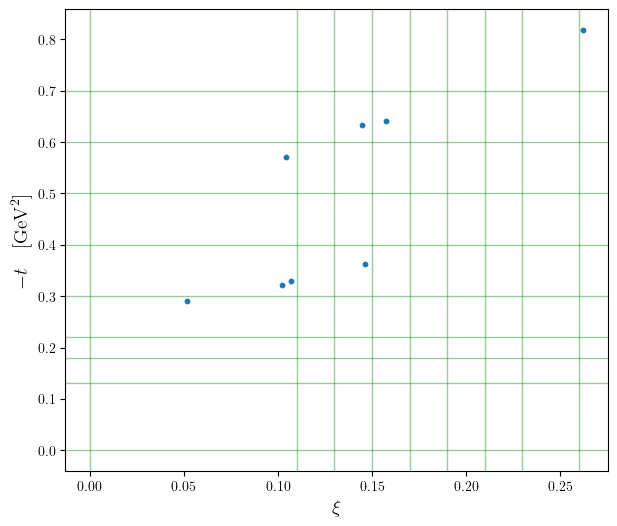

In [11]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSA.xi, BSA.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

In [12]:
################# Customization for 4-CFF DR model ###################
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)
        self.n2 = nn.Linear(20, 25)
        self.n3 = nn.Linear(25, 2)

        self.n1p = nn.Linear(1, 7)
        self.n2p = nn.Linear(7, 5)
        self.n3p = nn.Linear(5, 1)

    def forward(self, x):

        x0 = x

        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)

        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)

        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)

        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
        return output

In [13]:
# Define the 4-CFF DR model
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BM10, g.cff.DispersionCFF):
    def build_net(self):
        """Overriding the default architecture and optimizer"""
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.05)
        return nn_model, optimizer

    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)

    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)

    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)

    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)

    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)


## Loading model ensembles from a single analysis

In [14]:
def load_model_ensemble(path, model_class, name="Loaded Model"):
    """
    Load a saved ensemble model from a .pt file and restore the `th_model` instance.

    Parameters
    ----------
    path : str
        Path to the saved .pt file.
    model_class : class
        The class used to define the model (e.g., `NNTest_DR`).
    name : str
        A display name for the model, used for plots or printing.

    Returns
    -------
    th_model : instance of model_class
        Restored model with `.nets` loaded and ready to use.
    metadata : dict
        Dictionary with optional metadata (history, test_history, etc.).

    Raises
    ------
    FileNotFoundError
        If the .pt file is not found.
    KeyError
        If essential keys are missing in the saved file.
    """

    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    print(f"📂 Loading model from: {path}")
    data = torch.load(path, map_location='cpu')

    # Check required fields
    if 'nets' not in data:
        raise KeyError("Missing key 'nets' in the saved file.")
    
    output_layer = data.get('output_layer', [])
    if not isinstance(output_layer, list):
        print("Warning: 'output_layer' is not a list. Proceeding anyway.")

    th_model = model_class(output_layer=output_layer)
    th_model.name = name
    th_model.nets = data['nets']

    # Optional metadata
    metadata = {
        'history': data.get('history'),
        'test_history': data.get('test_history'),
        'output_layer': output_layer,
        'name': data.get('name', name)
    }

    print(f"Model '{th_model.name}' successfully loaded with {len(th_model.nets)} nets.")
    return th_model, metadata



📂 Loading model from: /Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test/nets_DR_3.pt
Model 'Fit DR' successfully loaded with 10 nets.


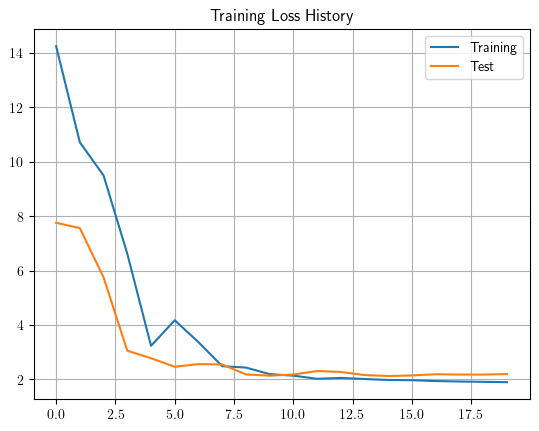

In [15]:
# Ensure CustomNetwork is defined BEFORE this
sys.modules['__main__'].CustomNetwork_4 = CustomNetwork

# For a single saved DR model
path = os.path.join(FITS_DIR, 'nets_DR_3.pt')
th, meta = load_model_ensemble(path, NNTest_DR, name="Fit DR")

# Access training history
if meta['history']:
    plt.plot(meta['history'], label="Training")
    plt.plot(meta['test_history'], label="Test")
    plt.legend()
    plt.title("Training Loss History")
    plt.grid()
    plt.show()

## D-term from a single model

In [ ]:
ptts = []
tm_list = np.linspace(0.1, 0.5, 10)

for tm in tm_list:
    ptb = g.dset[102][0].copy()
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)

In [ ]:
####### D-term estimate from DR fit with 2 and 4 CFFs ##########
D = []
std_values = []
net_indices = []
for th_model in [th]:
    print("\n---- [{} - {}] ----".format(th_model.name, th_model.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for i, net in enumerate(th_model.nets):
            th_model.nn_model, th_model.nn_mean, th_model.nn_std = net
            Ds.append(float(th_model.m.subtraction(pt).detach().numpy() * 18. / 25.))
            th_model.cffs_evaluated = False
        net_indices.append(i)
        Ds = np.array(Ds)
        D_std = Ds.std()
        std_values.append(D_std)
        print("{:.3f}, {:.3f}: {:.3f} +- {:.3f}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th_model.m.parameters['nnet'] = 'ALL'
    D.append(A)

In [ ]:
# Comparison with KM15 model
# Comparison plot for D-terms from DR and DR_4 models
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
#CADS = np.array(D[1])

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.axhline(y=0, linewidth=0.5, color='k')
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')

# Loop over loaded results to plot each D-term
ax.errorbar(CDS[:, 0], CDS[:, 1], CDS[:, 2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='Good Nets') #H and E with DR
#ax.errorbar(CADS[:, 0] + 0.01, CADS[:, 1], CADS[:, 2], linestyle='None',
#            elinewidth=2, capsize=3, capthick=2, marker='o', color='indianred', label='Best Models')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4.5, 1)
ax.legend(loc=4, handlelength=2.5,
          prop=matplotlib.font_manager.FontProperties(size="large")).set_frame_on(False)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.02))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.0))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))

# D-term estimate from Ensemble Analysis

In [28]:
comparison_dir = Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/Results/Comparison_CFFs")
comparison_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
'''
#sys.modules['__main__'].CustomNetwork_4 = CustomNetwork
# Load saved DR models
path_full = os.path.join(FITS_DIR, "th_combined_full.pt")
path_bestmodels = os.path.join(FITS_DIR, "th_combined_bestmodels.pt")
path_goodnets = os.path.join(FITS_DIR, "th_combined_goodnets.pt")

th_full, _ = load_model_ensemble(path_full, NNTest_DR, name="Full Ensemble (DR)")
th_bestmodels, _ = load_model_ensemble(path_bestmodels, NNTest_DR, name="Best Models (DR)")
th_goodnets, _ = load_model_ensemble(path_goodnets, NNTest_DR, name="Good Nets (DR)")

# Prepare list of models for evaluation
models_th = [th_full, th_bestmodels, th_goodnets] 
'''

📂 Loading model from: /Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test/th_combined_full.pt
Model 'Full Ensemble (DR)' successfully loaded with 50 nets.
📂 Loading model from: /Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test/th_combined_bestmodels.pt
Model 'Best Models (DR)' successfully loaded with 50 nets.
📂 Loading model from: /Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test/th_combined_goodnets.pt
Model 'Good Nets (DR)' successfully loaded with 43 nets.


In [21]:
#sys.modules['__main__'].CustomNetwork_4 = CustomNetwork
FITS_DIR6 = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test1'
FITS_DIR11 = '/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test2'
# Load saved DR models
path_CLAS6 = os.path.join(FITS_DIR6, "th_combined_goodnets.pt")
path_CLAS11 = os.path.join(FITS_DIR11, "th_combined_goodnets.pt")

th_CLAS6, _ = load_model_ensemble(path_CLAS6, NNTest_DR, name="CLAS 6 GeV")
th_CLAS11, _ = load_model_ensemble(path_CLAS11, NNTest_DR, name="CLAS 6+11 GeV")

# Prepare list of models for evaluation
models_th = [th_CLAS6, th_CLAS11] 

📂 Loading model from: /Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test1/th_combined_goodnets.pt
Model 'CLAS 6 GeV' successfully loaded with 45 nets.
📂 Loading model from: /Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test2/th_combined_goodnets.pt
Model 'CLAS 6+11 GeV' successfully loaded with 40 nets.


In [22]:
ptts = []
tm_list = np.linspace(0.1, 0.5, 10)

for tm in tm_list:
    ptb = g.dset[102][0].copy()
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)

In [23]:
D = []
std_values = []
net_indices = []

for th_model in models_th:
    print("\n---- [{} - {}] ----".format(th_model.name, th_model.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for i, net in enumerate(th_model.nets):
            th_model.nn_model, th_model.nn_mean, th_model.nn_std = net
            Ds.append(float(th_model.m.subtraction(pt).detach().numpy() * 18. / 25.))
            th_model.cffs_evaluated = False
        net_indices.append(i)
        Ds = np.array(Ds)
        D_std = Ds.std()
        std_values.append(D_std)
        print("{:.3f}, {:.3f}: {:.3f} +- {:.3f}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th_model.m.parameters['nnet'] = 'ALL'
    D.append(A)


---- [CLAS 6 GeV - N/A] ----
0.185, -0.500: 0.151 +- 0.432
0.185, -0.456: 0.103 +- 0.398
0.185, -0.411: 0.045 +- 0.382
0.185, -0.367: -0.017 +- 0.390
0.185, -0.322: -0.077 +- 0.410
0.185, -0.278: -0.159 +- 0.443
0.185, -0.233: -0.304 +- 0.560
0.185, -0.189: -0.477 +- 0.775
0.185, -0.144: -0.654 +- 1.043
0.185, -0.100: -0.832 +- 1.326

---- [CLAS 6+11 GeV - N/A] ----
0.185, -0.500: 0.163 +- 0.533
0.185, -0.456: 0.113 +- 0.437
0.185, -0.411: 0.047 +- 0.360
0.185, -0.367: -0.019 +- 0.320
0.185, -0.322: -0.073 +- 0.333
0.185, -0.278: -0.144 +- 0.370
0.185, -0.233: -0.274 +- 0.450
0.185, -0.189: -0.449 +- 0.574
0.185, -0.144: -0.615 +- 0.779
0.185, -0.100: -0.778 +- 1.021


/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_71230/2383417691.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th_model.m.subtraction(pt).detach().numpy() * 18. / 25.))


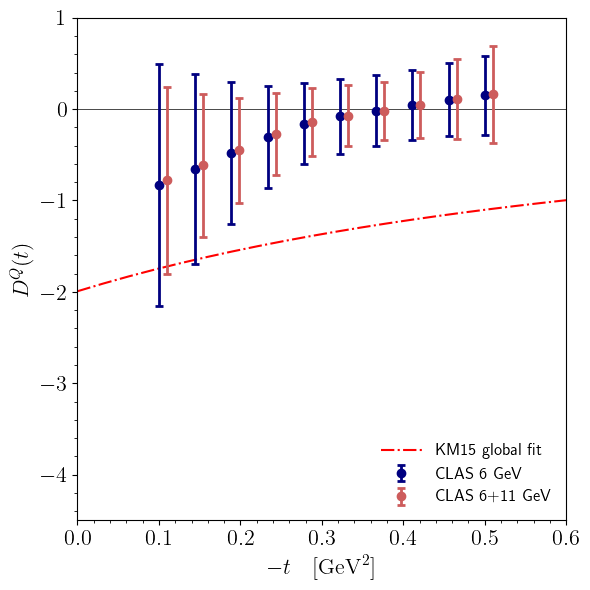

In [29]:
# Comparison with KM15 model
# Comparison plot for D-terms from DR and DR_4 models
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])


fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.axhline(y=0, linewidth=0.5, color='k')
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')

# Loop over loaded results to plot each D-term
ax.errorbar(CDS[:, 0], CDS[:, 1], CDS[:, 2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='CLAS 6 GeV') #H and E with DR
ax.errorbar(CADS[:, 0] + 0.01, CADS[:, 1], CADS[:, 2], linestyle='None',
            elinewidth=2, capsize=3, capthick=2, marker='o', color='indianred', label='CLAS 6+11 GeV')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4.5, 1)
ax.legend(loc=4, handlelength=2.5,
          prop=matplotlib.font_manager.FontProperties(size="large")).set_frame_on(False)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.02))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.0))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))

plt.tight_layout()

fig.savefig(os.path.join(comparison_dir, "D-ter_Comp_CLAS.png"))